# VISION TRANSFORMER (VIT)## Relicate the Vit paper

While a convolutional neural network (CNN) uses convolutions as learning layers, a Transformer architecture uses [attention mechanism](https://arxiv.org/abs/1706.03762).

Transformers is a state-of-the-art architecture originally designed to work on one-dimensional (1D) text sequences.

The Vision Transformer [ViT](https://arxiv.org/abs/2010.11929) architecture is designed to adapt the original Transformer architecture to vision use casesgao gain a better understanding of the **Transformer** architecture, we will build the ViT model from the scratch and replicate the [ViT paper](https://arxiv.org/abs/2010.11929).

# ViT architecture
<img src="https://github.com/AlaGrine/Artwork_classification_in_PyTorch/blob/main/results/ViT_architecture.png?raw=true" alt="ViT architecture" width=900/>

### Mathematically

There are 4 equations:

| Equation | Formula |
| ----- | ----- |
| **Equation1: Patch embedding** | $$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$ |
| **Equation2: MSA block - Multi-head Self Attention** | $$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$ |
| **Equation3: MLP block - Multi-later Perceptron** | $$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$  |
| **Equation4: Output** | $$
\begin{aligned}
y = LN(\mathbf{z}_{\ell}^{0})
\end{aligned}
$$ |$|


In [1]:
import pandas as pd
import numpy as np
import torch,torchvision,torchinfo
from torch import nn
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader
import os,random,pathlib
import matplotlib.pyplot as plt

## Get Data

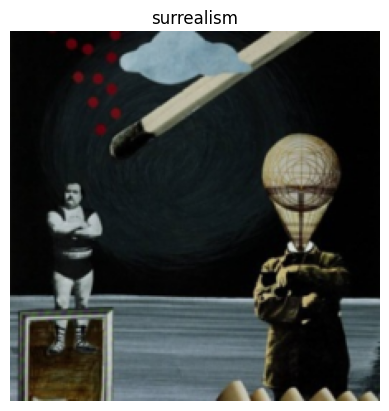

In [2]:
image_path = pathlib.Path("./artbench-10-imagefolder-split/")

# Create transforms (image preprocessing)
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

# Create Datasets
train_data = datasets.ImageFolder(root=image_path / "train",transform=manual_transforms)
test_data = datasets.ImageFolder(root=image_path / "test",transform=manual_transforms)
class_names = train_data.classes

# Create DataLoaders
BATCH_SIZE = 32
train_DataLoader = DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
test_DataLoader = DataLoader(test_data,shuffle=False,batch_size=BATCH_SIZE)

# Get an image example
image_batch,label_batch = next(iter(train_DataLoader))
random_index = random.choice(range(len(image_batch)))
image = image_batch[random_index]
image_permuted = image.permute(1,2,0)
plt.title(class_names[label_batch[random_index]])
plt.imshow(image_permuted)
plt.axis(False);

## Equation1: Patch embedding

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding of the input image. **E** stands for embedding.

In [3]:
H,W,C = (IMG_SIZE,IMG_SIZE,3) # height, width and number of color Channels
PATCH_SIZE = 16
N = H*W // PATCH_SIZE**2 # number of patches
D = PATCH_SIZE**2 * C # embedding dimension

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self,C,D,PATCH_SIZE):
        super().__init__()
        
        self.conv2d = nn.Conv2d(in_channels=C,
                                out_channels=D,
                                kernel_size=(PATCH_SIZE,PATCH_SIZE),
                                stride=PATCH_SIZE,
                                padding=0)
        self.flatten = nn.Flatten(start_dim=2,end_dim=-1)
    def forward(self,x):
        x = self.conv2d(x)
        print(f"shape after conv2D: {x.shape}")
        x = self.flatten(x)
        print(f"shape after flattening: {x.shape}")
        x = x.permute(0,2,1)
        print(f"desired shape: {x.shape}")
        return x

In [5]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
patchify = PatchEmbedding(C,D,PATCH_SIZE)
patchify
image_with_patch_embedding = patchify(image_batch)

shape after conv2D: torch.Size([32, 768, 14, 14])
shape after flattening: torch.Size([32, 768, 196])
desired shape: torch.Size([32, 196, 768])


In [6]:
torchinfo.summary(patchify,input_size=(BATCH_SIZE,C,IMG_SIZE,IMG_SIZE),col_names=["input_size",
                "output_size",
                "num_params",
                "kernel_size",
                "trainable"],col_width=15)

shape after conv2D: torch.Size([32, 768, 14, 14])
shape after flattening: torch.Size([32, 768, 196])
desired shape: torch.Size([32, 196, 768])


Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Kernel Shape    Trainable
PatchEmbedding                           [32, 3, 224, 224] [32, 196, 768]  --              --              True
├─Conv2d: 1-1                            [32, 3, 224, 224] [32, 768, 14, 14] 590,592         [16, 16]        True
├─Flatten: 1-2                           [32, 768, 14, 14] [32, 768, 196]  --              --              --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (G): 3.70
Input size (MB): 19.27
Forward/backward pass size (MB): 38.54
Params size (MB): 2.36
Estimated Total Size (MB): 60.17

In [7]:
## class Embedding
class_embedding = nn.Parameter(data=torch.randn(size=(BATCH_SIZE,1,D)))
image_with_patch_class_embeddings = torch.cat((class_embedding,image_with_patch_embedding),dim=1)
print(f"shape after patch and class embeddings: {image_with_patch_class_embeddings.shape}")

shape after patch and class embeddings: torch.Size([32, 197, 768])


In [8]:
## position embedding
position_embedding = nn.Parameter(data=torch.randn(size=(1,1+N,D)))
image_with_patch_class_position_embeddings = image_with_patch_class_embeddings + position_embedding
print(f"shape after patch, class and position embeddings: {image_with_patch_class_position_embeddings.shape}")

shape after patch, class and position embeddings: torch.Size([32, 197, 768])


In [9]:
# Putting it all together

In [10]:
class Embedding(nn.Module):
    def __init__(self,C,D,PATCH_SIZE,N,BATCH_SIZE,display_shapes=True):
        super().__init__()
        self.display_shapes = display_shapes
        self.conv2d = nn.Conv2d(in_channels=C,out_channels=D,kernel_size=PATCH_SIZE,stride=PATCH_SIZE,padding=0)
        self.flatten = nn.Flatten(start_dim=2,end_dim=-1)
        self.class_embedding = nn.Parameter(data=torch.randn(size=(BATCH_SIZE,1,D)),requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1,1+N,D),requires_grad=True)  
    def forward(self,x):
        if self.display_shapes:
            print(f"Input shape: {x.shape}")
        x = self.conv2d(x) # Conv2D
        if self.display_shapes:
            print(f"shape after conv2D: {x.shape}")
        x = self.flatten(x) # Flatten
        if self.display_shapes:
            print(f"shape after flatten: {x.shape}")
        x = x.permute(0,2,1)
        if self.display_shapes:
            print(f"shape after patch embedding: {x.shape}")
        x = torch.cat((self.class_embedding,x),dim=1) # append class embedding
        if self.display_shapes:
            print(f"shape after class and patch embedding: {x.shape}")
        x = x + self.position_embedding # add position embedding
        if self.display_shapes:
            print(f"output shape: {x.shape}")
        return x

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# patch+class+position embedding of one image
embedding_layer_1 = Embedding(C,D,PATCH_SIZE,N,1,display_shapes=True)
image_embedding = embedding_layer_1(image.unsqueeze(0))
print()
# patch+class+position embedding of a batch of images
embedding_layer_32 = Embedding(C,D,PATCH_SIZE,N,BATCH_SIZE,display_shapes=True)
batch_embedding = embedding_layer_32(image_batch)

Input shape: torch.Size([1, 3, 224, 224])
shape after conv2D: torch.Size([1, 768, 14, 14])
shape after flatten: torch.Size([1, 768, 196])
shape after patch embedding: torch.Size([1, 196, 768])
shape after class and patch embedding: torch.Size([1, 197, 768])
output shape: torch.Size([1, 197, 768])

Input shape: torch.Size([32, 3, 224, 224])
shape after conv2D: torch.Size([32, 768, 14, 14])
shape after flatten: torch.Size([32, 768, 196])
shape after patch embedding: torch.Size([32, 196, 768])
shape after class and patch embedding: torch.Size([32, 197, 768])
output shape: torch.Size([32, 197, 768])


In [12]:
# total embedding params?
total_embedding_params = torchinfo.summary(embedding_layer_1).total_params
total_embedding_params

742656

## Equation2: MSA block - Multi-head Self Attention

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

In [13]:
class MultiheadSelfAttention_block(nn.Module):
    def __init__(self,D,N_HEADS,att_dropout=0,display_shapes=True):
        super().__init__()
        self.display_shapes = display_shapes
        self.LN = nn.LayerNorm(normalized_shape=D)
        self.MHA = nn.MultiheadAttention(D,N_HEADS,att_dropout)
    def forward(self,x):
        if self.display_shapes:
            print(f"Input shape of MHA block: {x.shape}")
        x = self.LN(x)
        if self.display_shapes:
            print(f"shape after layer norm:{x.shape}")
        attn_output,_ = self.MHA(query=x,key=x,value=x,need_weights=False)
        # Add the residual/skip connection
        x = attn_output + x
        if self.display_shapes:
            print(f"Output shape of MHA block: {x.shape}")
        return x

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

mha_block = MultiheadSelfAttention_block(D,12,att_dropout=0,display_shapes=True)
mha_block

MultiheadSelfAttention_block(
  (LN): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (MHA): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
)

In [15]:
# pass image_embedding through the MHA block
mha_output_1 = mha_block(image_embedding)
print()
# pass a batch of 32 image embeddings through the MHA block
mha_output_32 = mha_block(batch_embedding)

Input shape of MHA block: torch.Size([1, 197, 768])
shape after layer norm:torch.Size([1, 197, 768])
Output shape of MHA block: torch.Size([1, 197, 768])

Input shape of MHA block: torch.Size([32, 197, 768])
shape after layer norm:torch.Size([32, 197, 768])
Output shape of MHA block: torch.Size([32, 197, 768])


## Equation3: MLP block - Multi-later Perceptron

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$

> The MLP contains two layers with a GELU non-linearity.

the structure of our MLP block will be:

`layer normalization -> linear layer -> non-linear layer (GELU) -> dropout -> linear layer -> dropout`


In [16]:
class MultiLayerPerceptron_block(nn.Module):
    def __init__(self,D,mlp_size=3072,dropout=0.1,display_shapes=True):
        """embedding shape = (batch_size,patch_size+1,D) --> D is the embedding dim"""
        super().__init__()
        self.display_shapes = display_shapes
        self.layer_norn = nn.LayerNorm(normalized_shape=D)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=D,out_features=mlp_size),# expand to mlp size (3072)
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,out_features=D), # compress back to embedding dimendion (D)
            nn.Dropout(p=dropout)
        )
    def forward(self,x):
        if self.display_shapes:
            print(f"Input shape to MLP_block: {x.shape}")
        mlp_output = self.mlp(x)
        # Add the residual/skip connection
        x = mlp_output + x
        if self.display_shapes:
            print(f"Output shape from the MLP_block: {x.shape}")
        return x

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

MLP_SIZE = 3072
mlp_bloc = MultiLayerPerceptron_block(D,mlp_size=MLP_SIZE,dropout=0.1,display_shapes=True)
mlp_bloc

MultiLayerPerceptron_block(
  (layer_norn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
)

In [18]:
# pass the output of the MHA block (1 image embedding) throuh the MLP block
mlp_output_1 = mlp_bloc(mha_output_1)
print()
# pass the output of the MHA block (32 image embeddings) throuh the MLP block
mlp_output_32 = mlp_bloc(mha_output_32)

Input shape to MLP_block: torch.Size([1, 197, 768])
Output shape from the MLP_block: torch.Size([1, 197, 768])

Input shape to MLP_block: torch.Size([32, 197, 768])
Output shape from the MLP_block: torch.Size([32, 197, 768])


In [19]:
# Putting it all together: create the Transformer Encoder

In [20]:
class Transformer_Encoder_block(nn.Module):
    def __init__(self,D, N_HEADS, att_dropout=0, mlp_size=3072, dropout=0.1,display_shapes=True):
        super().__init__()
        self.display_shapes = display_shapes
        self.MHA_block = MultiheadSelfAttention_block(D, N_HEADS, att_dropout,display_shapes=display_shapes)
        self.MLP_block = MultiLayerPerceptron_block(D, mlp_size=3072, dropout=0.1,display_shapes=display_shapes)
    def forward(self,x):
        x = self.MHA_block(x)
        x = self.MLP_block(x)
        return x

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
transformer_encoder = Transformer_Encoder_block(D, N_HEADS=12, att_dropout=0, mlp_size=3072, dropout=0.1,display_shapes=False)

transformer_encoder(image_embedding)

tensor([[[-0.2498, -1.4697, -0.3917,  ..., -0.7760,  1.2220,  0.3082],
         [-0.5564,  0.2097, -0.6212,  ..., -0.0501, -1.0690, -1.1697],
         [-1.5793, -0.8871, -0.7735,  ...,  2.6121,  0.2533,  0.4889],
         ...,
         [ 0.7595,  0.4229,  0.1175,  ..., -0.6296,  1.6541,  0.6377],
         [-0.0344, -0.8407, -0.4748,  ..., -0.5454,  0.1023,  2.8163],
         [-1.4014, -0.5673,  1.7155,  ..., -0.2425,  1.8234, -0.3359]]],
       grad_fn=<AddBackward0>)

In [22]:
# display summary of the transformer_encoder block
torchinfo.summary(transformer_encoder,input_size=(1,N+1,D), # 1: batch_size | N: number of patches | D: embedding dimension; 
                  col_names=["input_size","output_size","num_params","kernel_size","trainable"],
                  col_width=15) 

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Kernel Shape    Trainable
Transformer_Encoder_block                [1, 197, 768]   [1, 197, 768]   --              --              True
├─MultiheadSelfAttention_block: 1-1      [1, 197, 768]   [1, 197, 768]   --              --              True
│    └─LayerNorm: 2-1                    [1, 197, 768]   [1, 197, 768]   1,536           --              True
│    └─MultiheadAttention: 2-2           --              [1, 197, 768]   2,362,368       --              True
├─MultiLayerPerceptron_block: 1-2        [1, 197, 768]   [1, 197, 768]   1,536           --              True
│    └─Sequential: 2-3                   [1, 197, 768]   [1, 197, 768]   --              --              True
│    │    └─Linear: 3-1                  [1, 197, 768]   [1, 197, 3072]  2,362,368       --              True
│    │    └─GELU: 3-2                    [1, 197, 3072]  [1, 197, 3072]  --              --              --
│    │ 

# ViT model

In [23]:
class ViT(nn.Module):
    def __init__(self,
                 BATCH_SIZE=1,
                 H=224,W=224,C=3, # image params: height, width and number of color Channels
                 PATCH_SIZE=16,
                 embedding_dropout=0.1, # add Dropout layer after Embedding 
                 N_HEADS=12, att_dropout=0, mlp_size=3072,mlp_dropout=0.1, # transformer_encoder_block params
                 num_transformer_blocks:int=12, # number of transformer_encoder blocks
                 num_classes=1000, # number of classes returned by the classifier
                 display_sahpes = False
                ):
        super().__init__()
        
        self.display_sahpes = display_sahpes
        
        # 1. Calculate number of patches and embedding dimension
        self.N = H*W // (PATCH_SIZE**2) # number of patches
        self.D = (PATCH_SIZE**2) * C # embedding dimension
        
        # 2. Create patch_embedding
        self.patch_embedding = Embedding(C, self.D, PATCH_SIZE,self.N,BATCH_SIZE,display_shapes=display_sahpes)
        
        # 3. Embedding dropout (Appendix B.1)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 3. Create Transformer Encoder blocks (default = 12 blocks)
        self.transformer_encoder_blocks = nn.Sequential(*[Transformer_Encoder_block(self.D,N_HEADS, att_dropout=att_dropout, 
                                                                                    mlp_size=mlp_size,dropout=mlp_dropout,
                                                                                    display_shapes=display_sahpes) 
                                                          for _ in range(num_transformer_blocks)
                                                         ])
        # 4. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=D),
            nn.Linear(in_features=D,
                      out_features=num_classes)
        )
        
    def forward(self,x):
        print(f"Input shape to ViT model: {x.shape}")
        x = self.patch_embedding(x)
        x = self.embedding_dropout(x) # Create embedding dropout
        x = self.transformer_encoder_blocks(x)
        
        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index
        print(f"Output shape from ViT model: {x.shape}")
        return x

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

vit = ViT(BATCH_SIZE=32,
         H=224,W=224,C=3, # image params: height, width and number of color Channels
         PATCH_SIZE=16,
         embedding_dropout=0.1, # add Dropout layer after Embedding 
         N_HEADS=12, att_dropout=0, mlp_size=3072,mlp_dropout=0.1, # transformer_encoder_block params
         num_transformer_blocks=12, # number of transformer_encoder blocks
         num_classes=len(class_names))
vit

ViT(
  (patch_embedding): Embedding(
    (conv2d): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=-1)
  )
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder_blocks): Sequential(
    (0): Transformer_Encoder_block(
      (MHA_block): MultiheadSelfAttention_block(
        (LN): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (MHA): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (MLP_block): MultiLayerPerceptron_block(
        (layer_norn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    

In [25]:
# display summary of the ViT model
torchinfo.summary(vit,input_size=(32,3,224,224),
                  col_names=["input_size","output_size","num_params","kernel_size","trainable"],
                  col_width=15) 

Input shape to ViT model: torch.Size([32, 3, 224, 224])
Output shape from ViT model: torch.Size([32, 10])


Layer (type:depth-idx)                             Input Shape     Output Shape    Param #         Kernel Shape    Trainable
ViT                                                [32, 3, 224, 224] [32, 10]        --              --              True
├─Embedding: 1-1                                   [32, 3, 224, 224] [32, 197, 768]  175,872         --              True
│    └─Conv2d: 2-1                                 [32, 3, 224, 224] [32, 768, 14, 14] 590,592         [16, 16]        True
│    └─Flatten: 2-2                                [32, 768, 14, 14] [32, 768, 196]  --              --              --
├─Dropout: 1-2                                     [32, 197, 768]  [32, 197, 768]  --              --              --
├─Sequential: 1-3                                  [32, 197, 768]  [32, 197, 768]  --              --              True
│    └─Transformer_Encoder_block: 2-3              [32, 197, 768]  [32, 197, 768]  --              --              True
│    │    └─MultiheadSelfAtte

In [26]:
# pass the batch of 32 images through the ViT model --> return prediction logits 

vit.eval()
with torch.inference_mode():
    pred_logits = vit(image_batch)

pred_logits[:5,:] # prediction logits  of the first 5 images

Input shape to ViT model: torch.Size([32, 3, 224, 224])
Output shape from ViT model: torch.Size([32, 10])


tensor([[ 0.7401, -1.0301, -0.0701, -1.1720, -0.8559, -0.4006,  0.4953, -0.5548,
          0.9070,  0.6356],
        [ 0.6781, -0.8312, -0.1656, -1.0871, -0.5972, -0.2165,  0.6006, -1.0169,
          0.7439,  0.6016],
        [ 0.3467, -0.8001,  0.1032, -0.9958, -0.4431, -0.0765,  0.0914, -0.5000,
          0.6946,  0.4947],
        [ 0.4789, -0.7511, -0.4071, -1.2093, -0.6788, -0.3836,  0.2034, -0.7351,
          0.6777,  0.6356],
        [ 0.6438, -0.5467,  0.3517, -1.1030, -0.6447, -0.3136,  0.3086, -0.6494,
          0.7588,  0.7166]])